In [ ]:
#importing libraries
import pandas as pd
import numpy as np
from PIL import Image
import requests
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
from keras import callbacks

# Model Building Script

### Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import dataset
url = 'https://raw.githubusercontent.com/Shirone0110/BookCover/main/BookCover_2.csv'
df = pd.read_csv(url)

Since we use Google Drive to store images, we need to change the image path to Google Drive

In [ ]:
#change the path of image to google drive
for i in range(len(df.index)):
  path = '/content/drive/MyDrive/BookCovers/image_' + str(i) + '.jpg'
  df['image'][i] = path

### Preprocessing

We chose 3 categories that don't have a lot of overlapping books.

In [ ]:
#select categories
df = df[(df['category'] == 'Crime-Thriller') | (df['category'] == 'Food-Drink') |
        (df['category'] == 'Graphic-Novels-Anime-Manga')]
df.head()

,image,name,author,category
7900,/content/drive/MyDrive/BookCovers/image_7900.jpg,1984,George Orwell,Crime-Thriller
7901,/content/drive/MyDrive/BookCovers/image_7901.jpg,Man's Search For Meaning,Viktor E. Frankl,Crime-Thriller
7902,/content/drive/MyDrive/BookCovers/image_7902.jpg,Animal Farm,George Orwell,Crime-Thriller
7903,/content/drive/MyDrive/BookCovers/image_7903.jpg,The Husband's Secret,Liane Moriarty,Crime-Thriller
7904,/content/drive/MyDrive/BookCovers/image_7904.jpg,Gone Girl,Gillian Flynn,Crime-Thriller


Since there are overlapping books, we drop duplicated book names. We shuffle the dataset to make sure that each category doesn't come in a bunch together.

In [ ]:
#drop duplicated entries and shuffle the data
df = df.drop_duplicates(subset = 'name', keep = 'last')
df = df.sample(frac = 1)

Then we transform images into numpy array with normalized range [0, 1]

In [ ]:
#extract the image numpy array
X = [] 
for url in df['image']:
  im = cv2.imread(url) #read image
  arr = np.asarray(im) #turn image into numpy array
  arr = arr / 255      #transform the value range into [0, 1]
  X.append(arr)

X = np.array(X)

The categories are one-hot encoded.

In [ ]:
#label encoder to convert string labels into number IDs for multi-class classification
encoder = LabelEncoder()
numbered_labels = encoder.fit_transform(df["category"])
semantic_labels = list(encoder.classes_)
print("Y: Semantic Labels", semantic_labels)
Y = to_categorical(numbered_labels)

Y: Semantic Labels ['Crime-Thriller', 'Food-Drink', 'Graphic-Novels-Anime-Manga']


We split the dataset into 3 parts: train set, validation set, and test set.

In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [ ]:
#create validation set
validation_ratio = 0.10
validation_record_num = int(np.round(len(x_train) * validation_ratio))
x_val = x_train[:validation_record_num]
y_val = y_train[:validation_record_num]
x_train = x_train[validation_record_num:]
y_train = y_train[validation_record_num:]

Then we get the image shape for the neural network.

In [ ]:
# Get the image shape
image_shape = x_train.shape[1:]
image_shape 

(200, 128, 3)

## Configure the network architecture

We create a network according to the guide linked in References.

In [ ]:
# Create a function for each model. The configure function should return a compiled model
def configure_model(image_shape) -> Sequential:
  # Create the models architecture
  model = Sequential()
  # Add the first convolution layer
  model.add(Conv2D(30, kernel_size = (5, 5), activation="relu", input_shape=image_shape )) #Input 32 * 32 image with 3 channels

  # Add a pooling layer @
  # Pooling layer of 2 * 2 to extract the max value from a feature map
  model.add(MaxPooling2D(pool_size=(2, 2))) 

  # Add another convolution layer
  model.add( Conv2D(32, kernel_size = (5, 5), activation="relu") )

  # Add another pooling layer
  model.add(MaxPooling2D(pool_size=(2, 2))) 

  # Add a flattening layer to reduce the dementionality of the input array
  model.add(Flatten())

  # Add a layer with 1000 neurons
  model.add(Dense(1000, activation="relu"))

  # Dropout layer with dropout rate 50% @
  model.add(Dropout(0.5)) 

  # Add a layer with 500 neurons
  model.add(Dense(500, activation="relu"))

  #model.add(Dense(128, activation = 'relu'))

  # Dropout layer @
  model.add(Dropout(0.5)) 

  # Add a layer with 250 neurons
  model.add(Dense(250, activation="relu"))

  #Add a layer with 64 neurons
  #model.add(Dense(64, activation = "relu"))

  # Add a layer with number of outputs neurons
  model.add(Dense(3, activation="softmax")) #?

  # Compile the model 
  # Try optimizer = rmsprop instead of adam
  model.compile(loss = "categorical_crossentropy", optimizer="rmsprop",
                metrics = ["accuracy"])
  return model

In [ ]:
model = configure_model(image_shape)
# Check the network architecture
print("---------- Model Structure ----------")
model.summary()

---------- Model Structure ----------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 196, 124, 30)      2280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 62, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 58, 32)        24032     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 47, 29, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43616)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              43617000  
_________________________________________________________________
dropout_2 (Dropo

We use earlystopping to stop the model from overfitting and fit the model.

In [ ]:
# Train model with earlystopping callback
# patience = 1/5 * epochs
print("---------- Training ----------")
earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', 
                                        patience = 2, restore_best_weights = True)
history = model.fit(x_train, y_train, batch_size = 128, epochs = 10, 
                    validation_data = (x_val, y_val), callbacks = [earlystopping])

---------- Training ----------
Epoch 1/10
15/15 [==============================] - 104s 7s/step - loss: 4.8766 - accuracy: 0.3682 - val_loss: 1.0673 - val_accuracy: 0.4375
Epoch 2/10
15/15 [==============================] - 102s 7s/step - loss: 1.1064 - accuracy: 0.4541 - val_loss: 1.0581 - val_accuracy: 0.5144
Epoch 3/10
15/15 [==============================] - 106s 7s/step - loss: 1.0558 - accuracy: 0.5052 - val_loss: 1.0778 - val_accuracy: 0.3894
Epoch 4/10
15/15 [==============================] - 102s 7s/step - loss: 1.0334 - accuracy: 0.4628 - val_loss: 0.9690 - val_accuracy: 0.5337
Epoch 5/10
15/15 [==============================] - 101s 7s/step - loss: 1.0057 - accuracy: 0.5395 - val_loss: 0.9678 - val_accuracy: 0.5817
Epoch 6/10
15/15 [==============================] - 103s 7s/step - loss: 1.3262 - accuracy: 0.5641 - val_loss: 1.0146 - val_accuracy: 0.4183
Epoch 7/10
15/15 [==============================] - 102s 7s/step - loss: 0.8288 - accuracy: 0.6240 - val_loss: 0.9584 - val

Then we evalute the model on test set.

In [ ]:
# evaluate on test set
model.evaluate(x_test, y_test)

22/22 [==============================] - 10s 438ms/step - loss: 0.9560 - accuracy: 0.5403


[0.9559932351112366, 0.5403458476066589]

To get probability for each category, we use <code>model.predict</code>. However, we didn't have enough time to make use of this.

In [ ]:
#predict test set
probs = model.predict(x_test)

Observe the model's accuracy.

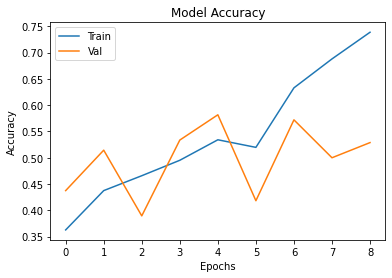

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

And see if the model finished training by observing model's loss.

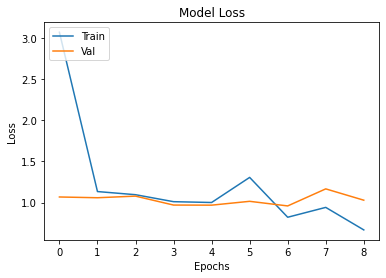

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# References

https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/  
https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8  
https://towardsdatascience.com/convolutional-neural-networks-for-beginners-using-keras-and-tensorflow-2-c578f7b3bf25  
https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/  
https://www.youtube.com/watch?v=iGWbqhdjf2s  
3Brown1Blue tutorial on Moodle